## Intent
* Implement error extrapolation
  * Check that the runs maintain 1st-order convergence before doing the extrapolation
  * 2\*coarse result - 1\*fine result = prediction based on those two runs (for 1st-order)

In [ ]:
#import math
import numpy as np
import matplotlib.pyplot as plt

## Utility Functions

In [ ]:
#cos(pi/2) is not exactly zero in python, this defines it to be zero
def cosine(angle):
    #return round(np.cos(theta),15)
    if angle == np.pi/2:
        return(0.0)
    else:
        return(np.cos(angle))

def cosine_array_version(angle_array):
    outs = []
    for angle in angle_array:
        if angle == np.pi/2:
            outs.append(0.0)
        else:
            outs.append(np.cos(angle))
    return(np.array(outs))

def sine(theta):
    #return round(np.sin(theta),15)
    return(np.sin(theta))

In [ ]:
def sph_to_cart(sph_coords_passed):
    # Converts input spherical coords to Cartesian coords
    # All individual coord variables are called [coord]_local in order to prevent any potential overlap with global variables
    # Inputs:
    # sph_coords_passed = numpy array [u, theta, phi, t] (where u = 1/r)
    # Outputs:
    # cart_coords = numpy array [x, y, z, t]

    # Make sure we don't accidentally change the original info
    sph_coords = np.copy(sph_coords_passed)

    # Pull out the spherical coords from the array
    r_local = sph_coords[0]
    theta_local = sph_coords[1]
    phi_local = sph_coords[2]
    t_local = sph_coords[3]

    # Calculate Cartesian coords
    x_local = r_local * sine(theta_local) * cosine(phi_local)
    y_local = r_local * sine(theta_local) * sine(phi_local)
    z_local = r_local * cosine(theta_local)

    # Package into an array to return
    cart_coords = np.array([x_local, y_local, z_local, t_local])

    return(cart_coords)

def cart_to_sph(cart_coords_passed):
    # Converts input Cartesian coords to spherical coords
    # All individual coord variables are called [coord]_local in order to prevent any potential overlap with global variables
    # Inputs:
    # cart_coords_passed = numpy array [x, y, z, t]
    # Outputs:
    # sph_coords = numpy array [u, theta, phi, t] (where u = 1/r)

    # Make sure we don't accidentally change the original info
    cart_coords = np.copy(cart_coords_passed)

    # Pull out Cartesian coords from array
    x_local = cart_coords[0]
    y_local = cart_coords[1]
    z_local = cart_coords[2]
    t_local = cart_coords[3]

    # Calculate spherical coords
    r_local = np.sqrt(x_local**2 + y_local**2 + z_local**2)
    theta_local = np.arccos(z_local/r_local)
    phi_local = np.arctan2(y_local, x_local)

    # Package into an array to return
    sph_coords = np.array([r_local, theta_local, phi_local, t_local])

    return(sph_coords)

## Differential Equation Handling

In [ ]:
# DE FUNCTION

def DE_using_r(current_state):
    # Houses the DEs to describe the system, now written just using r instead of u=1/r
    # Uses extended precision data type for a more accurate value
    # Inputs:
    # current_state = numpy array [r, theta, phi, t], current spacetime coords of photon
    # Outputs:
    # to_return = numpy array [dr/dsigma, dtheta/dsigma, dphi/dsigma, dt/dsigma],
	# rates of change WRT sigma for each coord

    # Pull out current r & theta (phi & t have no bearing on partials due to symmetry)
    r_now = np.longdouble(current_state[0])
    theta_now = np.longdouble(current_state[1])

    # R(r) value to calculate dr/dsigma
    r_testarg = ((r_now**2 + a**2 - (a*lam))**2 - (r_now**2 - 2*m*r_now + a**2 + q**2)\
				*(eta + (lam - a)**2))
    # Make sure it isn't negative before we pass it into a square root function
    if r_testarg < 0:
        r_testarg = 0
    drdsigma = np.sqrt(r_testarg)

    # THETA(theta) value to calculate dtheta/dsigma
    theta_testarg = (np.longdouble(eta) + (a*np.longdouble(cosine(theta_now)))**2 -\
                    (lam*np.longdouble(cosine(theta_now))/np.longdouble(sine(theta_now)))**2)
    # Make sure it isn't negative before passing it into a square root function
    if theta_testarg < 0:
        theta_testarg = 0
    dthetadsigma = -1*np.sqrt(theta_testarg)

    dphidsigma = (a * (r_now**2 + a**2 - a*lam) / (r_now**2 - 2*m*r_now + a**2 + q**2)\
				+ lam/(sine(theta_now)**2) - a)

    dtdsigma = ((r_now**2 + a**2)/(r_now**2 - 2*m*r_now + a**2 + q**2) *\
				(r_now**2 + a**2 - a*lam) + a*(lam - a*(sine(theta_now)**2)))

    to_return = np.array([drdsigma, dthetadsigma, dphidsigma, dtdsigma])

    return(to_return)


In [ ]:
# CARTESIAN STEP CALCULATION

#caclualtes the constants to see if they're conserved
def constants(x,y,z,delta_sigma):

  #uses spherical coordinates for the calcualtions
  r0 = np.sqrt(x**2 + y**2 + z**2)
  theta0 = np.arccos(z/r0)
  phi0 = np.arctan2(y, x)

  sph_pos = [r0,theta0,phi0,0]
  #print("sph_pos",sph_pos)

  # CARTESIAN 4-VELOCITY
  ux = sine(theta_d)*cosine(phi_d)
  uy = sine(theta_d)*sine(phi_d)
  uz = cosine(theta_d)
  ur = ux
  #print("ux uy uz ur",ux,uy,uz,ur)

  #utheta is down for increasing theta in spherical coords
  utheta = -1/r0*uz

  #uphi defaults(?) to theta_0 = pi/2 in the equatorial plane
  uphi = 1/(r0*sine(theta0))*uy
  #print("utheta uphi",utheta,uphi)

  # IMPORTANT CONSTANTS
  SIGMA = (r0)**2 + a**2 * cosine(theta0)**2
  #print('SIGMA =', SIGMA)

  delta = (r0)**2 - 2*m*r0 + a**2 + q**2
  #print('delta =', delta)

  gtt = -delta/SIGMA + (a**2 * sine(theta0)**2)/SIGMA
  #print('gtt =', gtt)

  gtphi = (a * sine(theta0)**2)/SIGMA * (q**2 - 2*m*r0)

  #sometimes gtphi = -0
  if (gtphi == 0):
      gtphi = abs(gtphi)
  #print('gtphi =', gtphi)


  grr = SIGMA/delta
  #print('grr =', grr)

  gthetatheta = SIGMA
  #print('gthetatheta =', gthetatheta)


  gphiphi = (-delta*a*a*sine(theta0)**4)/SIGMA + ((r0**2+a*a)**2*sine(theta0)**2)/SIGMA
  #print('gphiphi =', gphiphi)

  # CALCULATING ut

  #holds the coefficients for the quadratic to be solved for
  quadratic = [gtt, 2*gtphi*uphi, grr*ur**2 + gthetatheta*utheta**2 + gphiphi*uphi**2]

  #solves the quadratic for ut
  root = np.roots(list(quadratic))

  #--------------------------------
  #ensures that only the largest (positive) root is kept
  ut = np.max(root)
  assert ut > 0, "ut <= 0, should be > 0"
  #print('root of ut =', ut)
  #--------------------------------

  e = -(gtt * ut + gtphi * uphi)
  lz = gtphi * ut + gphiphi * uphi
  c = SIGMA**2 * utheta**2 - a**2 * e**2 * cosine(theta0)**2 + lz**2 * (cosine(theta0)/sine(theta0))**2

  lam = lz/e
  eta = c/e**2

  lz_diff = abs(r0-lz)

  # Calculate the derivatives in spherical coordinates
  derivs_sdc = delta_sigma * DE_using_r(sph_pos)

  # Pull out coordinate derivatives wrt sigma
  drds = derivs_sdc[0]/delta_sigma
  dthetads = derivs_sdc[1]/delta_sigma
  dphids = derivs_sdc[2]/delta_sigma

  phi_dir = np.arctan2(r0*dphids, drds)+phi0

  return [lz_diff,eta,c,r0,dthetads,phi_dir]


def step_direction_calc(cartesian_position, delta_sigma):
    # Handles conversion between Cartesian/spherical coords around the DE function call
    # All local variables have "_sdc" on the end to ensure no issues with global vs local variables
    # Inputs:
    # cartesian_position = numpy array of current position in Cartesian coords [x, y, z, t]
    # delta_sigma = sigma step size
    # Outputs:
    # cartesian_step = numpy array of step in Cartesian coords: [dx, dy, dz, dt]

    # Create a copy of position so we don't accidentally change the original
    cart_pos = np.copy(cartesian_position)
    #print(cart_pos)

    # Convert to spherical
    sph_pos = cart_to_sph(cart_pos)

    #print(sph_pos, '\n')

    # Pull out spherical coords individually for later
    r_sdc = sph_pos[0]
    theta_sdc = sph_pos[1]
    phi_sdc = sph_pos[2]

    # Calculate the derivatives in spherical coordinates
    derivs_sdc = delta_sigma * DE_using_r(sph_pos)

    # Pull out coordinate derivatives wrt sigma
    dr_sdc = derivs_sdc[0]
    dtheta_sdc = derivs_sdc[1]
    dphi_sdc = derivs_sdc[2]
    dt_sdc = derivs_sdc[3]


    # Convert to derivatives in Cartesian coords
    dx_sdc = dr_sdc*sine(theta_sdc)*cosine(phi_sdc) + dtheta_sdc*r_sdc*cosine(theta_sdc)*cosine(phi_sdc) - dphi_sdc*r_sdc*sine(theta_sdc)*sine(phi_sdc)
    dy_sdc = dr_sdc*sine(theta_sdc)*sine(phi_sdc) + dtheta_sdc*r_sdc*cosine(theta_sdc)*sine(phi_sdc) + dphi_sdc*r_sdc*sine(theta_sdc)*cosine(phi_sdc)
    dz_sdc = dr_sdc*cosine(theta_sdc) - dtheta_sdc*r_sdc*sine(theta_sdc)

    # Package as an array to send back
    cartesian_step = np.array([dx_sdc, dy_sdc, dz_sdc, dt_sdc])

    return(cartesian_step)

## RK4 Loop

In [ ]:
def cart_step_RK4(initial_cart_state, dsigma, sigma_stop):
    # Handles the main loop of RK4, alongside converting between spherical and cartesian values as necessary
    # Inputs:
    # initial_cart_state = numpy array [x, y, z, t] describing initial position
    # dsigma = sigma step size
    # sigma_stop = maximum allowed value of sigma (functions as end condition to prevent runaways)
    # Outputs:
    # cart_outs = numpy array of cartesian coords of calculated positions [[x, y, z, t], [x, y, z, t],...]

    # Make local copies so we know we're only working with the right things
    cart_state = np.copy(initial_cart_state)

    # Create output lists to append states to
    cart_outs = []
    direction_outs = []

    #holds the conserved quantities
    conserved = []

    # Set up our affine parameter
    sigma = 0

    # Step guess list so that we don't get an error the first time through the loop (will be overwritten)
    tot_step_guess = [0.0,0.0,0.0,0.0]

    # RK4 loop
    while sigma < sigma_stop:
        # Once we're far enough away, we're not going to be curving much anymore
        # I've included this to stop the loop early if we're going really far
        # out and will be encountering float overflow errors soon.
        current_radius = np.sqrt(cart_state[0]**2 + cart_state[1]**2 + cart_state[2]**2)
        if current_radius > 1e5:
            break

        # Append current coords, constants to output lists
        # (done here to sidestep final-step wonkiness by just not including the final step)
        cart_outs.append(np.copy(cart_state))
        #conserved.append(constants(cart_state[0],cart_state[1],cart_state[2],dsigma))

        # Update sigma
        sigma += dsigma

        # Step guess calculations
        # dsigma is multiplied in as part of step_direction_calc
        k1 = step_direction_calc(cart_state, dsigma)
        k2 = step_direction_calc(cart_state + k1/2, dsigma)
        k3 = step_direction_calc(cart_state + k2/2, dsigma)
        k4 = step_direction_calc(cart_state + k3, dsigma)

        # Sum into a total step guess
        tot_step_guess = (k1 + 2*k2 + 2*k3 + k4)/6
        cart_state += tot_step_guess

    # Turn output list into an array for ease of manipulation later
    cart_outs = np.array(cart_outs)
    #direction_outs = np.array(direction_outs)

    return(cart_outs)#, conserved, direction_outs)


# Automated calculation of run constants

In [ ]:
# BLACK HOLE PARAMETERS
m = 1.0
#make sure a^2+q^2 <= 1
a = -0.5
q = 0.0
assert a**2 + q**2 <= m**2, "That's un-physical! (a^2 + q^2 was greater than m^2)"

# INITIAL CONDITIONS
#r0 is the initial distance from the photon from the BH
#r0 = 10
#don't set r0 below 5, roundoff error may cause problems

r0_array = np.arange(9.5, 12.5, 0.5)
#print("r0_array\n", r0_array)

# theta0 and phi0 are the initial POSITION of the photon, along the x-axis
theta0 = np.pi/2
phi0 = 0

#Initial DIRECTION for photon, assumed to point in the y-z plane
phi_d = np.pi/2
# cos(theta_d) values -> theta_d values
cos_array = np.linspace(0, 0.9, 21)
#print(cos_array)
#print(np.linspace(0, 0.8, 17))
theta_d_array = np.arccos(cos_array)


#holds the conserved quantities e,lz and c
conserved = [[],[],[]]

# Step sizes of the three runs for each test
ds1 = 2**-8
ds2 = ds1/2
ds3 = ds2/2

# Lists to hold extrapolated runs, ending phi directions
final_pos_data = []
final_phi_ds = []

# (Re)calculate the conserved quantities for each trajectory
for r0 in r0_array:
    this_r_phis = []
    this_r_posns = []

    # Starting position in cartesian coords
    cart_starting_state = np.array([r0, 0., 0., 0.])

    for angle in theta_d_array:
        theta_d = angle

        ux = sine(theta_d)*cosine(phi_d)
        uy = sine(theta_d)*sine(phi_d)
        uz = cosine(theta_d)
        ur = ux
        #utheta is down for increasing theta in spherical coords
        utheta = -1/r0*uz
        #uphi defaults(?) to theta_0 = pi/2 in the equatorial plane
        uphi = 1/(r0*sine(theta0))*uy

        # IMPORTANT CONSTANTS
        SIGMA = (r0)**2 + a**2 * cosine(theta0)**2
        delta = (r0)**2 - 2*m*r0 + a**2 + q**2

        gtt = -delta/SIGMA + (a**2 * sine(theta0)**2)/SIGMA
        gtphi = (a * sine(theta0)**2)/SIGMA * (q**2 - 2*m*r0)
        #sometimes gtphi = -0
        if (gtphi == 0):
            gtphi = abs(gtphi)
        grr = SIGMA/delta
        gthetatheta = SIGMA
        gphiphi = (-delta*a*a*sine(theta0)**4)/SIGMA + ((r0**2+a*a)**2*sine(theta0)**2)/SIGMA

        # CALCULATING ut
        #holds the coefficients for the quadratic to be solved for
        quadratic = [gtt, 2*gtphi*uphi, grr*ur**2 + gthetatheta*utheta**2 + gphiphi*uphi**2]
        #solves the quadratic for ut
        root = np.roots(list(quadratic))
        #--------------------------------
        #ensures that only the largest (positive) root is kept
        ut = np.max(root)
        assert ut > 0, "ut <= 0, should be > 0"

        # Calculating the conserved quantities
        e = -(gtt * ut + gtphi * uphi)
        lz = gtphi * ut + gphiphi * uphi
        c = SIGMA**2 * utheta**2 - a**2 * e**2 * cosine(theta0)**2 + lz**2 * (cosine(theta0)/sine(theta0))**2
        lam = lz/e
        eta = c/e**2

        conserved[0].append(e)
        conserved[1].append(lz)
        conserved[2].append(c)

        # Function calls
        cResults1 = cart_step_RK4(cart_starting_state, ds1, 0.3)
        cResults2 = cart_step_RK4(cart_starting_state, ds2, 0.3)
        cResults3 = cart_step_RK4(cart_starting_state, ds3, 0.3)

        # Leave behind the time data
        cVals1 = cResults1[:, :-1]
        cVals2 = cResults2[::2, :-1]
        cVals3 = cResults3[::4, :-1]

        # Get rid of the identical first point in each run
        cPoints1 = cVals1[1:]
        cPoints2 = cVals2[1:]
        cPoints3 = cVals3[1:]

        # If one set of points is longer or shorter than the others, this part
        # catches that and trims all the arrays to be the same length as the
        # shortest one.
        len1 = len(cPoints1)
        len2 = len(cPoints2)
        len3 = len(cPoints3)

        if not((len1 == len2) and (len2 == len3)):
            # Could probably put a message here about "hey the runs were different lengths"
            # But eh. More work than I care to do right now.
            minlen = min([len1, len2, len3])
            cPoints1 = cPoints1[:minlen]
            cPoints2 = cPoints2[:minlen]
            cPoints3 = cPoints3[:minlen]

        # Displacement from run n to run n+1
        disp_12 = np.abs(cPoints2 - cPoints1)
        disp_23 = np.abs(cPoints3 - cPoints2)

        # Calculating magnitudes of the displacements
        mags_12 = np.zeros(len(disp_12))
        mags_23 = np.zeros(len(disp_23))
        for i in range(len(disp_12)):
            # Pull out displacement vector
            vec_12 = disp_12[i]
            vec_23 = disp_23[i]
            # Pythagorean theorem
            mag_12 = np.sqrt(np.sum(np.square(vec_12)))
            mag_23 = np.sqrt(np.sum(np.square(vec_23)))
            # Update the magnitudes array with the calculated value
            mags_12[i] = mag_12
            mags_23[i] = mag_23

        convergence_ratios = np.divide(mags_12, mags_23)
        avg_ratio = np.average(convergence_ratios)
        #assert np.round(avg_ratio) == 2, f"Convergence was not 1st-order at r0={r0}, average ratio was approx. {np.round(avg_ratio, 5)}"

        coarse = cResults2[::2]
        fine = cResults3[::4]

        lenCoarse = len(coarse)
        lenFine = len(fine)
        shorter = min(lenCoarse, lenFine)
        coarse = coarse[:shorter]
        fine = fine[:shorter]

        extrapolated = 2*fine - coarse
        this_r_posns.append(np.copy(extrapolated))

        directions = np.zeros_like(extrapolated)
        for i in range(len(extrapolated)):
            direction = step_direction_calc(extrapolated[i], ds3)
            directions[i] = direction

        dys = directions[:,1]
        dxs = directions[:,0]

        phi_vals = np.arctan2(dys, dxs)
        phi_lim = phi_vals[-1] - (np.pi/2)
        this_r_phis.append(phi_lim)
    final_phi_ds.append(np.copy(this_r_phis))
    final_pos_data.append(this_r_posns)

#print(np.shape(final_phi_ds))

#for i in range(len(r0_array)):
#    r0 = r0_array[i]
#    plt.figure()
#    plt.scatter(cos_array, final_phi_ds[i])
#    plt.title("$\\phi_{d, f}$ as a function of $\\cos(\\theta_{d,i})$, r0 = " + str(r0))
#    plt.xlabel("$\\cos(\\theta_{d,i})$")
#    plt.ylabel("$\\phi_{d, f}$ (rad)")
#    plt.show()
#    plt.close()


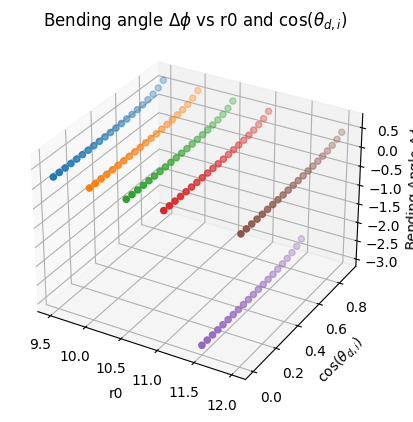

In [ ]:
fig, ax = plt.subplots(subplot_kw = {'projection':'3d'})
for i in range(len(r0_array)):
    r0 = r0_array[i]
    phis = final_phi_ds[i]
    ax.scatter(r0*np.ones_like(phis), cos_array, phis)

ax.set_xlabel("r0")
ax.set_ylabel("$ \\cos(\\theta_{d,i}) $")
ax.set_zlabel("Bending Angle $\\Delta\\phi_d$")
plt.title("Bending angle $\\Delta\\phi$ vs r0 and $\\cos(\\theta_{d,i})$")
plt.savefig("overall bending angle plot v1")
plt.show()
plt.close()

Weird example run except for its last point


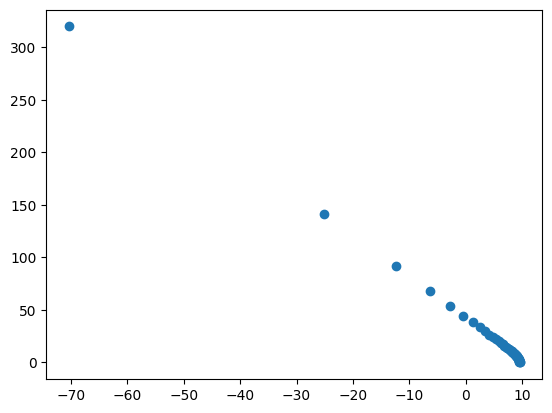

In [ ]:
# [0,0,:,0] for x
# []
# 0th index = list of r0=8 position data
# 0th index in that = that first run with a final phi direction of <1.5 rad
# every position in that run
# every x/y position (index 0/index 1 respectively)

interest_run = final_pos_data[0][0]
print("Weird example run except for its last point")
plt.scatter(interest_run[:,0], interest_run[:,1])

# Note to self about phi data
* Needs to be *bending angle*, not just direction - need to subtract $\frac{\pi}{2}$ from results

# ------------------------------------Running & Testing------------------------------------

## Plan
* Do 3 runs at $2^{-n}$, $2^{-(n+1)}$, and $2^{-(n+2)}$
* Verify 1st order convergence between them
* Do error extrapolation using the 2nd and 3rd runs
  * 2\*coarse result - 1\*fine result = prediction based on those two runs for 1st-order convergence
* Use positions generated by error extrapolation and feed them back into `step_direction_calc` to calculate direction of travel at those points
* Use those directions to find the final $\phi$ bending angle

... *All* that for each value of $\cos(\theta_{d,0})$ lol

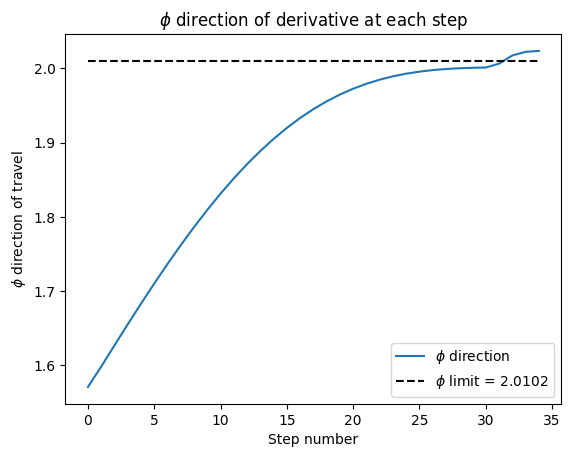

In [ ]:
# Jon's single phi bending angle calculation

# Define the step sizes to use
ds1 = 2**-8
ds2 = ds1/2
ds3 = ds2/2

# Define initial conditions in cartesian
cart_starting_state = np.array([r0, 0., 0., 0.])

# Function call!
cResults1 = cart_step_RK4(cart_starting_state, ds1, 0.25)
cResults2 = cart_step_RK4(cart_starting_state, ds2, 0.25)
cResults3 = cart_step_RK4(cart_starting_state, ds3, 0.25)

#---------------------------------------------------------------------------
# Analysis

# Leave behind the time data
cVals1 = cResults1[:, :-1]
cVals2 = cResults2[::2, :-1]
cVals3 = cResults3[::4, :-1]

# Get rid of the identical first point in each run
cPoints1 = cVals1[1:]
cPoints2 = cVals2[1:]
cPoints3 = cVals3[1:]

# If one set of points is longer or shorter than the others, this part
# catches that and trims all the arrays to be the same length as the
# shortest one.
len1 = len(cPoints1)
len2 = len(cPoints2)
len3 = len(cPoints3)

if not((len1 == len2) and (len2 == len3)):
    # Could probably put a message here about "hey the runs were different lengths"
    # But eh. More work than I care to do right now.
    minlen = min([len1, len2, len3])
    cPoints1 = cPoints1[:minlen]
    cPoints2 = cPoints2[:minlen]
    cPoints3 = cPoints3[:minlen]

# Displacement from run n to run n+1
disp_12 = np.abs(cPoints2 - cPoints1)
disp_23 = np.abs(cPoints3 - cPoints2)

# Calculating magnitudes of the displacements
mags_12 = np.zeros(len(disp_12))
mags_23 = np.zeros(len(disp_23))
for i in range(len(disp_12)):
    # Pull out displacement vector
    vec_12 = disp_12[i]
    vec_23 = disp_23[i]
    # Pythagorean theorem
    mag_12 = np.sqrt(np.sum(np.square(vec_12)))
    mag_23 = np.sqrt(np.sum(np.square(vec_23)))
    # Update the magnitudes array with the calculated value
    mags_12[i] = mag_12
    mags_23[i] = mag_23

convergence_ratios = np.divide(mags_12, mags_23)
avg_ratio = np.average(convergence_ratios)
assert np.round(avg_ratio) == 2, f"Convergence was not 1st-order, average ratio was approx. {np.round(avg_ratio, 5)}"

coarse = cResults2[::2]
fine = cResults3[::4]

lenCoarse = len(coarse)
lenFine = len(fine)
shorter = min(lenCoarse, lenFine)
coarse = coarse[:shorter]
fine = fine[:shorter]

extrapolated = 2*coarse - fine
#plt.plot(extrapolated[:,0], extrapolated[:,1])

directions = np.zeros_like(extrapolated)
for i in range(len(extrapolated)):
    direction = step_direction_calc(extrapolated[i], ds3)
    directions[i] = direction

dys = directions[:,1]
dxs = directions[:,0]

phi_vals = np.arctan2(dys, dxs)
phi_lim = np.average(phi_vals[-int(len(phi_vals)/5):])


plt.figure()
plt.plot(phi_vals, label = "$\\phi$ direction")
plt.plot(np.ones_like(phi_vals)*phi_lim, c = 'k', ls = '--', label = f"$\\phi$ limit = {np.round(phi_lim, 4)}")
plt.title("$\\phi$ direction of derivative at each step")
plt.xlabel("Step number")
plt.ylabel("$\\phi$ direction of travel")
plt.legend()
plt.show()
plt.close()

0.0455637157127312*x + 0.100331582684828


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

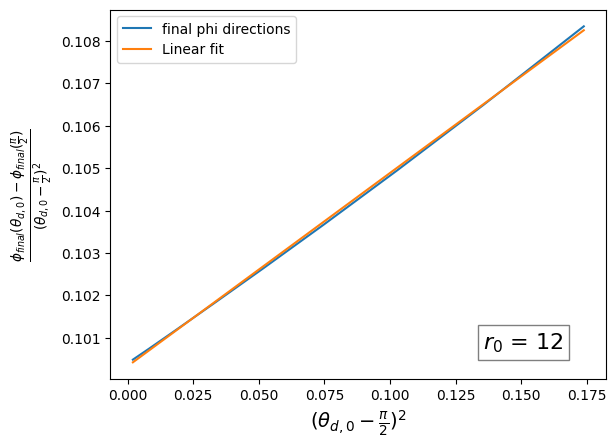

In [ ]:
from sympy import symbols, Eq
from google.colab import files

#grid = x values, compact_new = y values and order is the polynomial order
def fit_poly(order,grid,compact_new):
    #this finds the coefficients attached to each term
    fit = np.polyfit(grid, compact_new, order)

    #holds the y values
    y_val = []

    #these allow the function to be expressed as symbols
    x = symbols('x')
    y = []

    #the main loop that goes over all the terms and multiplies them by their coefficients
    index = -1
    for i in grid:
        index += 1
        y_val.append(0)
        y.append(0)
        for j in range(order+1):
            y_val[index] += fit[j] * (i)**(order-j)

            #this is just for expressing the approximation with symbols
            y[index] += fit[j]*x**(order-j)

    #finds the difference between the data and the approximate curve
    difference = []
    for j in range(len(grid)):
        difference.append(abs(y_val[j]-compact_new[j]))

    #returns the y values and then the symbols
    return y_val,y,difference



#final_phi_ds[0] contains the phi values at r0 = 9.5
#theta_d_array[0] = pi/2

phi_y_axis = []
phi_x_axis = []

for i in range(9):
  phi_y_axis.append((final_phi_ds[5][i+1]-final_phi_ds[5][0])/(theta_d_array[i+1]-np.pi/2)**2)
  phi_x_axis.append((theta_d_array[i+1]-np.pi/2)**2)

y_fit,y_name,y_difference = fit_poly(1,phi_x_axis,phi_y_axis)

print(y_name[0])


plt.plot(phi_x_axis,phi_y_axis, label = "final phi directions")
plt.plot(phi_x_axis,y_fit, label = "Linear fit")
plt.legend()
plt.xlabel(r"$(\theta_{d,0} - \frac{\pi}{2})^2$", fontsize=14)
plt.text(phi_x_axis[-2],phi_y_axis[1], r"$r_0$ = 12", fontsize = 16, bbox = dict(facecolor = 'white', alpha = 0.5))
plt.ylabel(r"$\frac{\phi_{final}(\theta_{d,0}) - \phi_{final}(\frac{\pi}{2})}{(\theta_{d,0} - \frac{\pi}{2})^2}$", fontsize=14)
plt.savefig("phi_fit_r12_a-5.pdf", bbox_inches='tight')
files.download("phi_fit_r12_a-5.pdf")